# Miniproject 1: Cliff Walking

Elective module: Deep Reinforcement Learning<br>
Stephan Seliner, Alex Koller<br>
OST - Spring semester 2022<br>

In [1]:
# Magic
%matplotlib inline

# Imports
import random
import numpy as np
import matplotlib.pyplot as plt

# helper functions
def get_plotname(sarsa):
    if sarsa:
        return 'plots/SARSA_'
    else:
        return 'plots/Q-L_'

## Environment Class

In [2]:
class Cliff:
    """
    Reinforcement Learning environment for Cliff Walking.
    
    Attributes
    ----------
    rows : int
        Number of rows
    cols : int
        Number of columns
    end_flag : bool
        Flag if reached end or fell of cliff
    pos : tuple of int
        Current position
    S : tuple of int
        Start position of Agent as (x, y)
    G : tuple of int
        Goal position of Agent as (x, y)
    actions : list of str
        List with possible actions in environment
    board : 2d list of int
        Board as list

    Methods
    -------
    step(action: int)
        Moves Agent to the next state
    reset()
        Resets the Agent back to start
    """
    def __init__(self, rows: int=4, cols: int=12, s: tuple[int,int]=(3,0), g: tuple[int,int]=(3,11)):
        """
        Constructor of Cliff class

        Parameters
        ----------
        rows : int, default: 4
            Number of rows
        cols : int, default: 12
            Number of columns
        s : tuple of int, default: (3,0)
            Starting position of Agent as (x, y)
        g : tuple of int, default: (3,11)
            End position of Agent as (x, y)
        """
        # Number of rows
        self.rows = rows
        # Number of columns
        self.cols = cols
        # Flag if reached end or fell of cliff
        self.end_flag = False
        # Current position
        self.pos = s
        # Start position
        self.S = s
        # End position
        self.G = g
        # Possible actions
        self.actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']
        # Create board
        self.board = np.zeros([self.rows, self.cols])
        # add cliff marked as -1
        self.board[self.rows-1, 1:self.cols-1] = -1

    def step(self, action: int) -> tuple[tuple[int, int], int, bool]:
        """
        Checks if actions is possible and if so, moves the agent to the next state.

        Parameters
        ----------
        action : int
            Index of actions, which is to perform

        Returns
        -------
        pos : tuple of int
            Next position the agent will be in
        reward : int
            The reward the agent gets for moving there
        end_flag : bool
            Flag if agent has reached the goal or fell off of cliff
        
        """
        if self.actions[action] == 'UP':
            nxtPos = (self.pos[0] - 1, self.pos[1])
        elif self.actions[action] == 'DOWN':
            nxtPos = (self.pos[0] + 1, self.pos[1])
        elif self.actions[action] == 'LEFT':
            nxtPos = (self.pos[0], self.pos[1] - 1)
        else:
            nxtPos = (self.pos[0], self.pos[1] + 1)
        
        # check legitimacy
        if nxtPos[0] >= 0 and nxtPos[0] <= self.rows - 1:
            if nxtPos[1] >= 0 and nxtPos[1] <= self.cols - 1:
                self.pos = nxtPos

        if self.pos == self.G:
            self.end_flag = True
            self.reward = 0
        elif self.board[self.pos] == -1:
            self.end_flag = True
            self.reward = -100
        else:
            self.reward = -1

        return self.pos, self.reward, self.end_flag

    def reset(self) -> tuple[int, int]:
        """
        Resets the environment by setting the end_flag to False and sets agent back to start position

        Returns
        -------
        pos : tuple of int
            Start position of agent
        
        """
        self.end_flag = False
        self.pos = self.S
        return self.pos


## Agent Class

In [3]:
class Agent:
    """
    Reinforcement Learning Agent for Cliff Walking.
    
    Attributes
    ----------
    env : Cliff
        Cliff Walking environment
    actions : list of str
        List with possible actions in environment
    alpha : float
        Learning factor
    gamma : float
        Discount factor
    epsilon : float
        Exploration-Exploitation-Probability
    epsilon_min : float
        Minimal value of epsilon
    epsilon_decay_rate : float
        Decay rate of epsilon per episode
    episodes : int
        Number of episodes
    use_sarsa : bool
        Whether to use SARSA or Q-Learning

    Methods
    -------
    _greedy_policy(q_values: list[int, int, int], state: tuple[int,int])
        Choose an action based on a epsilon greedy policy.
    sarsa(current_state: tuple[int,int], current_action: int, reward: int, next_state: tuple[int,int], next_action: int)
        State Action Reward State Action algorithm for learning a MDP.
    q_learning(current_state: tuple[int,int], current_action: int, reward: int, next_state: tuple[int,int])
        Q-Learning algorithm for finding an optimal policy in a MDP.
    _train()
        Train method contains the actual reinforcement learning process
    _print_Q()
        Print a easy to read table of Q values
    _create_Q_dict()
        Create a dictionary to store Q values
    plt_Q_RPE(state: tuple[int, int], action: int)
        Plot Q values and RPE over episodes
    plt_steps_epsilon()
        Plot steps needed to reach goal and the decay of epsilon over all episodes
    """
    def __init__(self, env: Cliff, alpha: float=0.1, gamma: float=0.99, epsilon: float=0.99, sarsa: bool=True, epsilon_min: float=0.01, epsilon_decay_rate: float=0.9998, episodes: int=20000):
        """
        Constructor of Agent class

        Parameters
        ----------
        env : Cliff, default: None
            Cliff Walking environment
        alpha : float, default: 0.1
            Learning factor
        gamma : float, default: 0.99
            Discount factor
        epsilon : float, default: 0.99
            Exploration-Exploitation-Probability
        sarsa : bool, default: True
            Whether to use SARSA or Q-Learning
        epsilon_min : float, default: 0.01
            Minimal value of epsilon
        epsilon_decay_rate : float, default: 0.9998
            Decay rate of epsilon per episode
        episodes : int, default: 20000
            Number of episodes
        """
        # Environment
        self.env = env
        self.actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']
        # Hyperparameters of SARSA / Q-Learning
        self.alpha = alpha
        self.gamma = gamma
        # Hyperparameters of epsilon greedy policy
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay_rate = epsilon_decay_rate
        # Training values
        self.episodes = episodes
        self.use_sarsa = sarsa
        # Monitoring setup
        self.num_actions = len(self.actions)
        self.rpe = 0
        self.q_values = np.zeros((self.env.rows, self.env.cols, self.num_actions))

        # Monitoring
        self.steps = []
        self.epsilon_t = []
        self.ep_rewards = []
        self.Q_s_a_t = np.zeros((self.env.rows, self.env.cols, self.num_actions, episodes))
        self.RPE_s_a_t = np.zeros((self.env.rows, self.env.cols, self.num_actions, episodes))
        self.episode_s_a_t = np.zeros((self.env.rows, self.env.cols, self.num_actions, episodes))
        # Create Q value dict
        self.Q = {}
        self.create_Q_dict()

    def greedy_policy(self, q_values: list[int, int, int], state: tuple[int,int]) -> int:
        """ 
        Choose an action based on a epsilon greedy policy.    
        A random action is selected with epsilon probability, else with probability of 1 - epsilon, select the action with highest reward.
        
        Parameters
        ----------
        q_values : list[int, int, int], default: None
            Already 'learned' Q values
        state : tuple[int,int], default: None
            Position of Agent
            
        Returns
        -------
        int
            Action to take
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(q_values[state])

    def sarsa(self, current_state: tuple[int,int], current_action: int, reward: int, next_state: tuple[int,int], next_action: int) -> None:
        """ 
        State Action Reward State Action algorithm for learning a MDP.
        Calculates reward prediction error and Q values.
        
        Parameters
        ----------
        current_state : tuple[int, int], default: None
            Current position of Agent
        current_action : int, default: None
            Current action to take
        reward : int, default: None
            Reward until now
        nextt_state : tuple[int, int], default: None
            Next position of Agent
        next_action : int, default: None
            Next action to take
        """
        self.rpe = reward + self.gamma * self.q_values[next_state][next_action] - self.q_values[current_state][current_action]
        self.q_values[current_state][current_action] += self.alpha * self.rpe

    def q_learning(self, current_state: tuple[int,int], current_action: int, reward: int, next_state: tuple[int,int]) -> None:
        """ 
        Q-Learning algorithm for finding an optimal policy in a MDP.
        Calculates reward prediction error and Q values.
        
        Parameters
        ----------
        current_state : tuple[int, int], default: None
            Current position of Agent
        current_action : int, default: None
            Current action to take
        reward : int, default: None
            Reward until now
        nextt_state : tuple[int, int], default: None
            Next position of Agent
        """
        self.rpe = reward + self.gamma * max(self.q_values[next_state])- self.q_values[current_state][current_action]
        self.q_values[current_state][current_action] += self.alpha * self.rpe


    def train(self) -> None:
        """
        Train method contains the actual reinforcement learning process
        """
        for e in range(self.episodes):
            # Reset environment and set starting position
            self.env.reset()
            current_state = self.env.pos
            # Choose first action
            current_action = self.greedy_policy(self.q_values, current_state)
            # Reset episode monitoring
            steps_needed = 0
            reward_sum = 0
            done = False

            while not done:
                next_state, reward, done = self.env.step(current_action)

                next_action = self.greedy_policy(self.q_values, next_state)

                if self.use_sarsa:
                    self.sarsa(current_state=current_state, current_action=current_action,
                                reward=reward, next_state=next_state, next_action=next_action)
                else:
                    self.q_learning(current_state=current_state, current_action=current_action,
                                reward=reward, next_state=next_state)

                # track history during episode
                steps_needed += 1
                reward_sum += reward
                self.Q[current_state][self.actions[current_action]] = self.q_values[current_state][current_action]
                self.Q_s_a_t[current_state][current_action][e] = self.q_values[current_state][current_action]
                self.RPE_s_a_t[current_state][current_action][e] = self.rpe
                self.episode_s_a_t[current_state][current_action][e] = e

                # S <- S'
                current_state = next_state
                # A <- A'
                current_action = next_action

            # Monitoring for each episode
            self.steps.append(steps_needed)
            self.ep_rewards.append(reward_sum)

            self.epsilon_t.append(self.epsilon)
            self.epsilon = max(self.epsilon * self.epsilon_decay_rate, self.epsilon_min)

    def print_Q(self) -> None:
        """
        Print a easy to read table of Q values
        """
        for i in range(0, self.env.rows):
            print('-------------------------------------------------')
            for j in range(len(self.actions) + 1):
                out = '| '
                for k in range(0, self.env.cols):
                    if j == len(self.actions):
                        out += 'KOR: (' + str(i) + ', ' + str(k) + ') | '
                    else:
                        if self.actions[j] in self.Q[(i, k)]:
                            token = str(self.actions[j])[0:1] + ': {0: 08.3f}'.format(self.Q[(i, k)][self.actions[j]])
                            out += token + ' | '
                print(out)
        print('-------------------------------------------------') 

    def create_Q_dict(self) -> None:
        """
        Create a dictionary to store Q values
        """
        self.Q = {}
        for i in range(self.env.rows):
            for j in range(self.env.cols):
                self.Q[(i, j)] = {}
                for x in self.actions:
                    self.Q[(i, j)][x] = 0

    def plt_Q_RPE(self, state: tuple[int, int], action: int) -> None:
        """
        Plot Q values and RPE over episodes
        
        Parameters
        ----------
        state : tuple[int, int], default: None
            Position on grid, where values are coming from
        action : int, default: None
            Action the agent would take in this state
        """
        plt.figure(figsize=[25, 10])
        plt.plot(self.episode_s_a_t[state][action], self.Q_s_a_t[state][action], '.', markersize=1.5, label='Q(S{}, {})'.format(state, self.actions[action]))
        plt.plot(self.episode_s_a_t[state][action], self.RPE_s_a_t[state][action], '.', markersize=1.5, label='RPE')
        plt.title('RPE and Q at state S{} for action {}'.format(state, self.actions[action]), fontsize=20)
        plt.legend(loc='best', markerscale=5)
        plt.xlabel('No. of episodes')
        plt.ylabel('Q & RPE')
        plt.grid()
        
        # save figure as png
        plt_name = get_plotname(self.use_sarsa) + 'Q-RPE_S{}-{}.png'.format(state, self.actions[action])
        plt.savefig(plt_name)

    def plt_steps_epsilon(self) -> None:
        """
        Plot steps needed to reach goal and the decay of epsilon over all episodes
        """
        plt.figure(figsize=[25, 10])
        plt.subplot(1, 2, 1)
        plt.plot(self.epsilon_t, '.', markersize=1.5, label='epsilon')
        plt.title('Epsilon decay over all episodes')
        plt.legend(loc='best', markerscale=5)
        plt.xlabel('No. of episodes')
        plt.ylabel('epsilon')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(self.steps, '.', markersize=1.5, label='steps')
        plt.title('Steps taken to reach goal per episode')
        plt.legend(loc='best', markerscale=5)
        plt.xlabel('No. of episodes')
        plt.ylabel('Steps taken')
        plt.grid()
        
        # save figure as png
        plt_name = get_plotname(self.use_sarsa) + 'eps_steps.png'
        plt.savefig(plt_name)

## Solve control problem with SARSA

-------------------------------------------------
| U: -010.349 | U: -009.827 | U: -009.170 | U: -008.451 | U: -007.692 | U: -006.907 | U: -006.102 | U: -005.280 | U: -004.449 | U: -003.613 | U: -002.776 | U: -001.952 | 
| D: -010.349 | D: -009.828 | D: -009.171 | D: -008.451 | D: -007.692 | D: -006.907 | D: -006.101 | D: -005.279 | D: -004.448 | D: -003.612 | D: -002.774 | D: -001.951 | 
| R: -010.349 | R: -009.827 | R: -009.170 | R: -008.451 | R: -007.692 | R: -006.906 | R: -006.100 | R: -005.279 | R: -004.448 | R: -003.612 | R: -002.774 | R: -001.952 | 
| L: -010.349 | L: -009.827 | L: -009.170 | L: -008.451 | L: -007.693 | L: -006.907 | L: -006.101 | L: -005.280 | L: -004.449 | L: -003.613 | L: -002.775 | L: -001.952 | 
| KOR: (0, 0) | KOR: (0, 1) | KOR: (0, 2) | KOR: (0, 3) | KOR: (0, 4) | KOR: (0, 5) | KOR: (0, 6) | KOR: (0, 7) | KOR: (0, 8) | KOR: (0, 9) | KOR: (0, 10) | KOR: (0, 11) | 
-------------------------------------------------
| U: -010.824 | U: -010.100 | U: -009.308 |

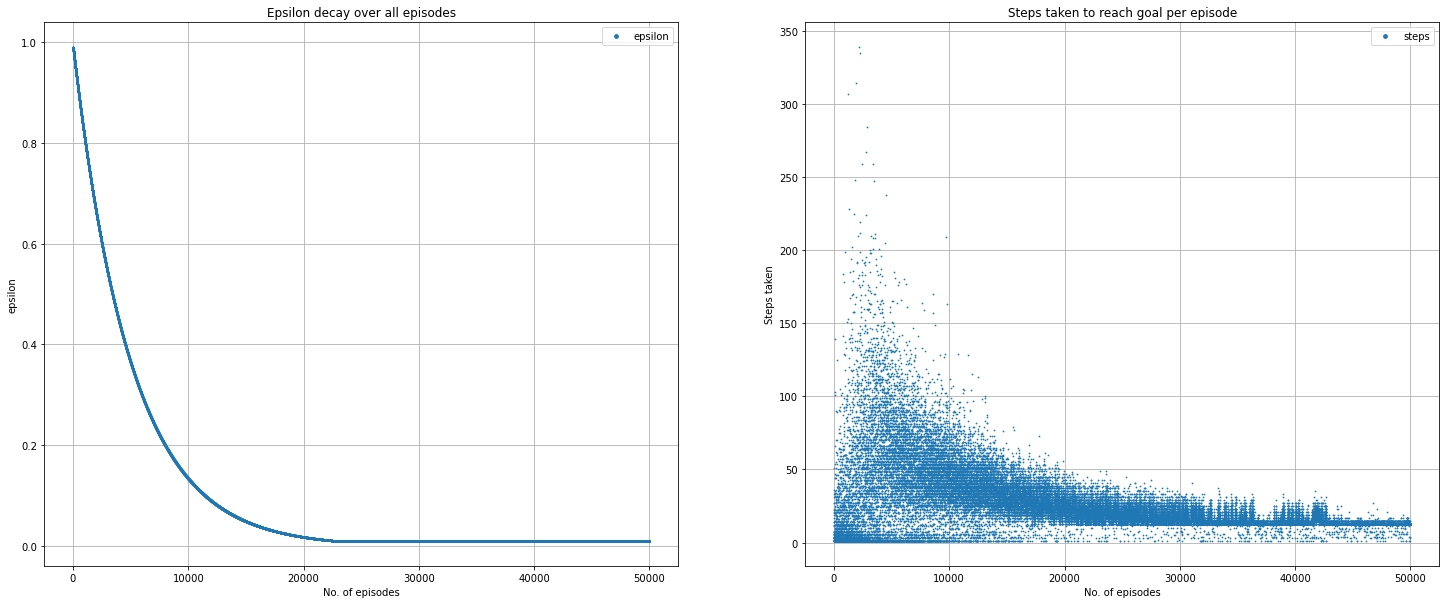

In [4]:
# Create the environment
sarsa_env = Cliff()
# Create the agent with SARSA
sarsa_agent = Agent(env=sarsa_env, alpha=0.001, sarsa=True, episodes=50000)
# Train the agent
sarsa_agent.train()
# Print Q table
sarsa_agent.print_Q()
# Plot steps and epsilon decay
sarsa_agent.plt_steps_epsilon()

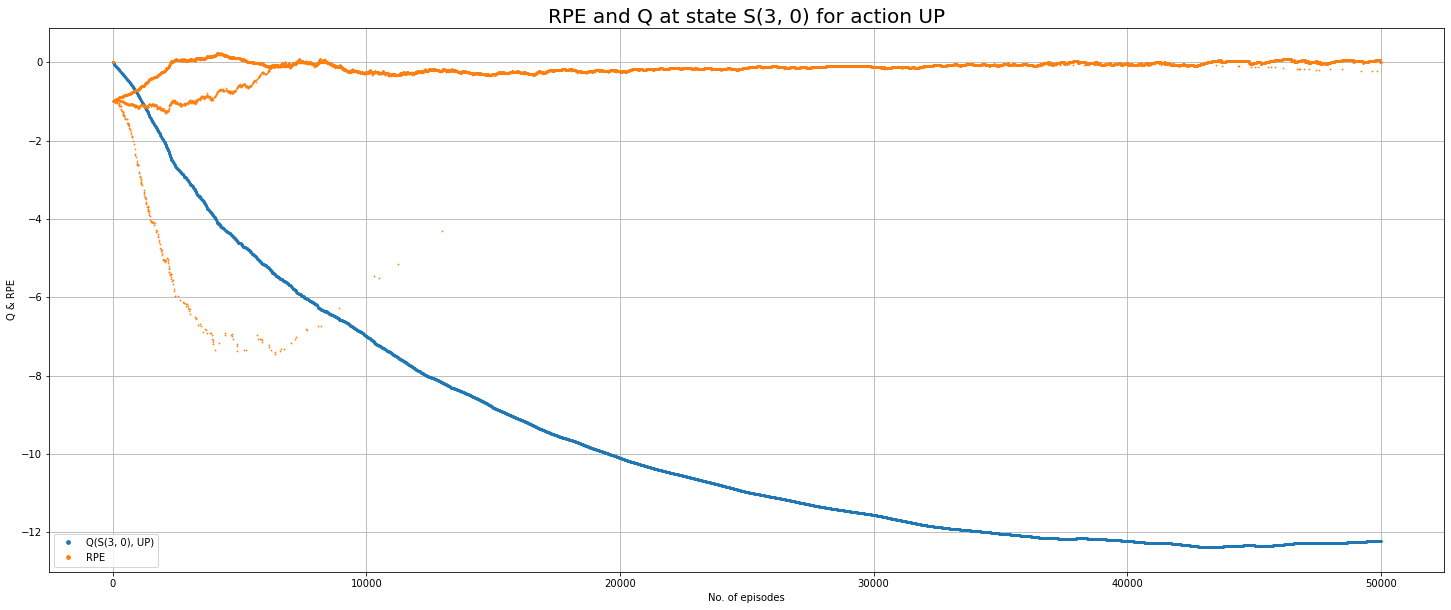

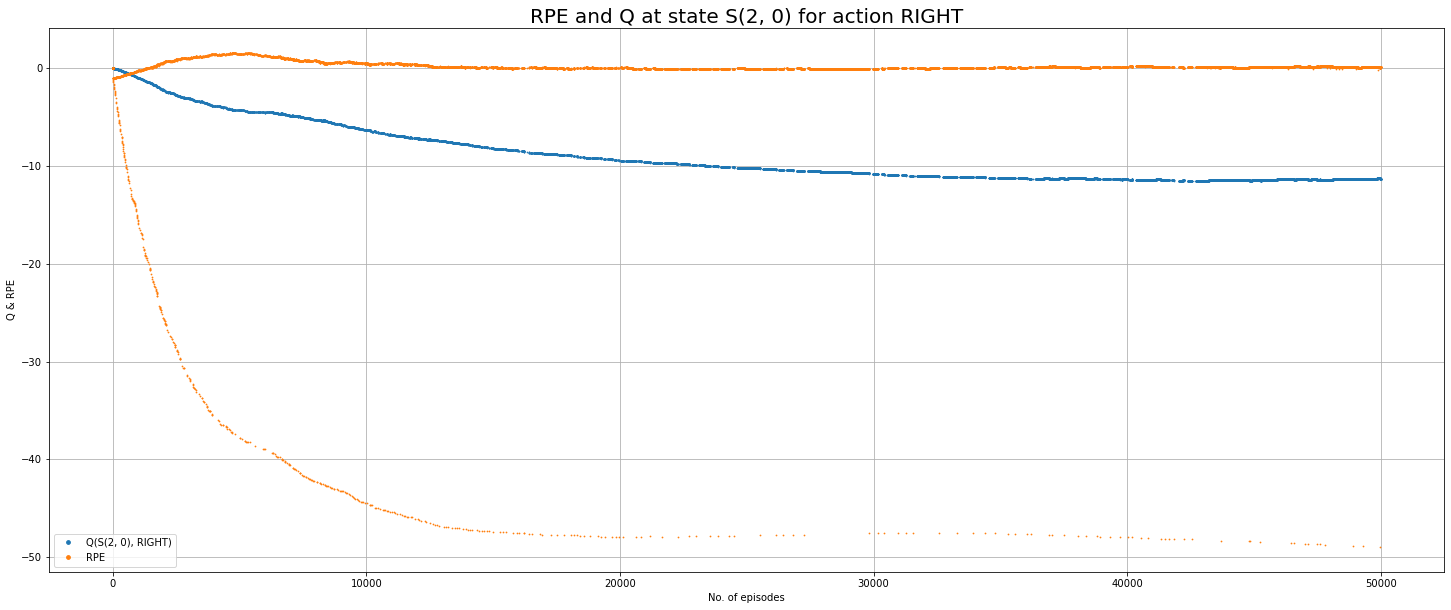

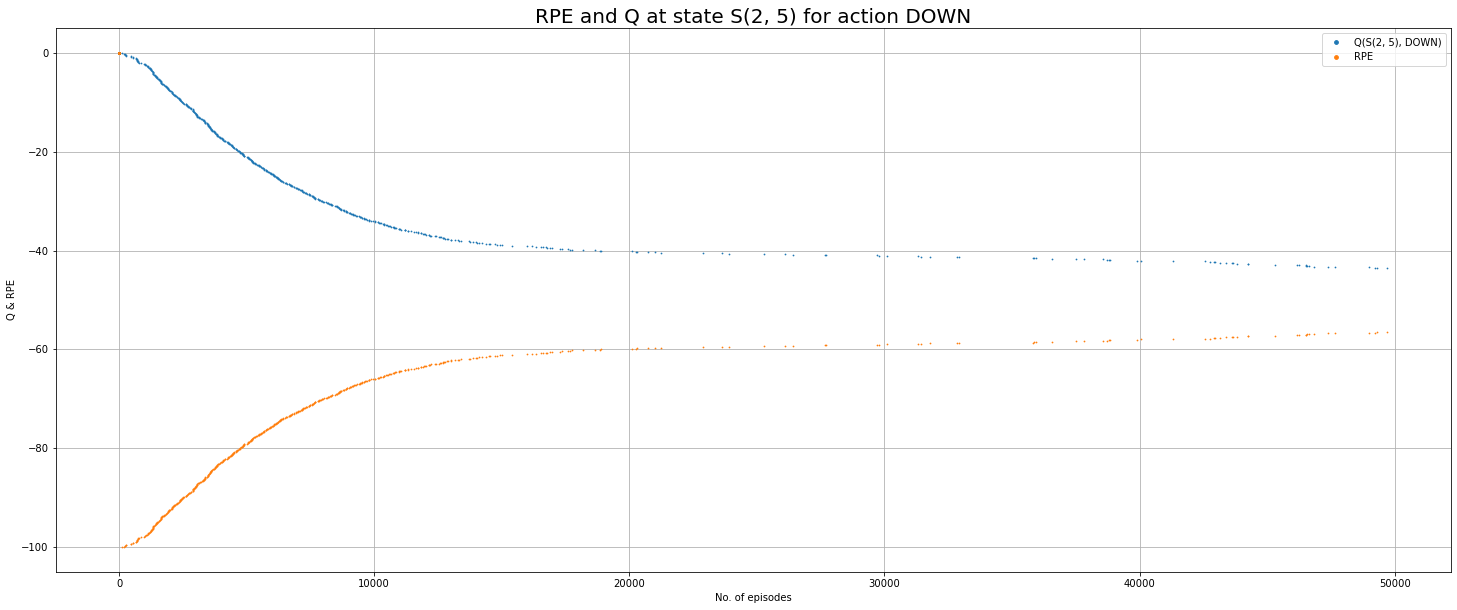

In [5]:
# Start position with action up
sarsa_agent.plt_Q_RPE((3,0), 0)
# One above start position with action right
sarsa_agent.plt_Q_RPE((2,0), 2)
# Position in middle of board with action down
sarsa_agent.plt_Q_RPE((2,5), 1)

## Solve control problem with Q-Learning


-------------------------------------------------
| U: -012.791 | U: -012.101 | U: -011.324 | U: -010.458 | U: -009.556 | U: -008.648 | U: -007.723 | U: -006.791 | U: -005.850 | U: -004.898 | U: -003.936 | U: -002.969 | 
| D: -012.244 | D: -011.361 | D: -010.466 | D: -009.562 | D: -008.648 | D: -007.726 | D: -006.793 | D: -005.852 | D: -004.901 | D: -003.940 | D: -002.970 | D: -001.990 | 
| R: -012.244 | R: -011.361 | R: -010.466 | R: -009.562 | R: -008.648 | R: -007.726 | R: -006.793 | R: -005.852 | R: -004.901 | R: -003.940 | R: -002.970 | R: -002.960 | 
| L: -012.611 | L: -012.729 | L: -012.166 | L: -011.310 | L: -010.452 | L: -009.558 | L: -008.645 | L: -007.723 | L: -006.788 | L: -005.841 | L: -004.892 | L: -003.921 | 
| KOR: (0, 0) | KOR: (0, 1) | KOR: (0, 2) | KOR: (0, 3) | KOR: (0, 4) | KOR: (0, 5) | KOR: (0, 6) | KOR: (0, 7) | KOR: (0, 8) | KOR: (0, 9) | KOR: (0, 10) | KOR: (0, 11) | 
-------------------------------------------------
| U: -013.117 | U: -012.247 | U: -011.361 |

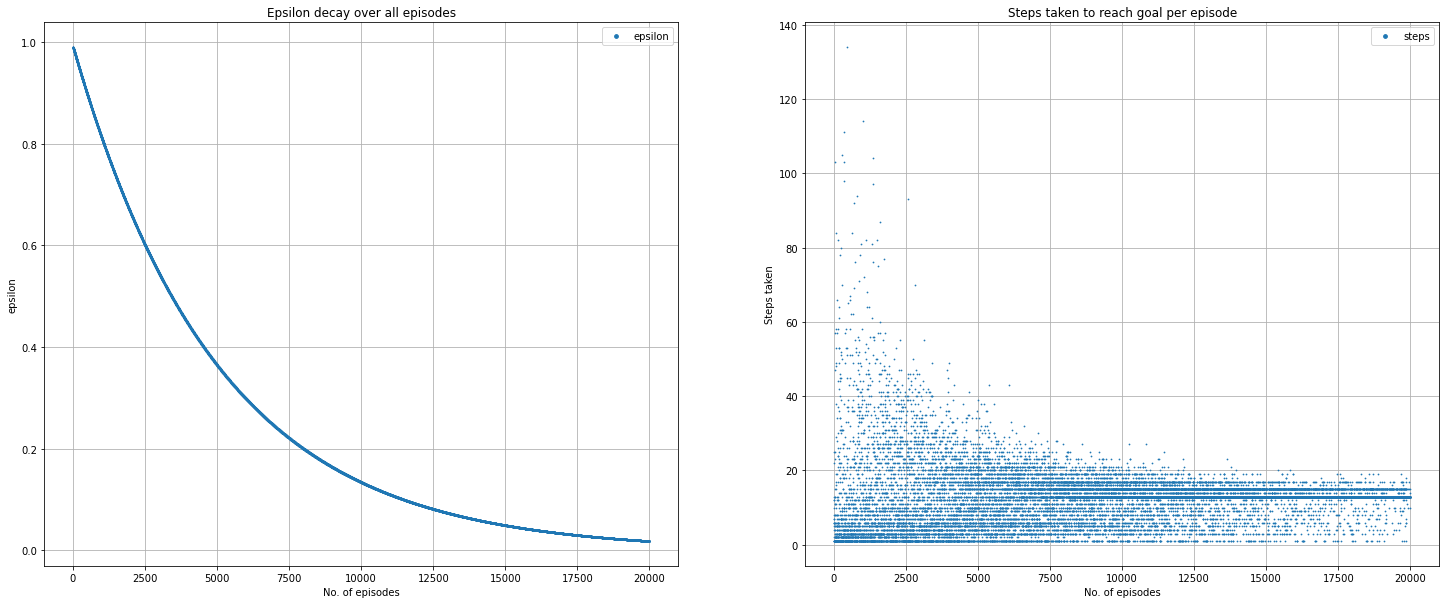

In [6]:
# Create the environment
q_env = Cliff()
# Create the agent with Q-Learning
q_agent = Agent(env=q_env, sarsa=False)
# Train the agent
q_agent.train()
# Print Q table
q_agent.print_Q()
# Plot steps and epsilon decay
q_agent.plt_steps_epsilon()

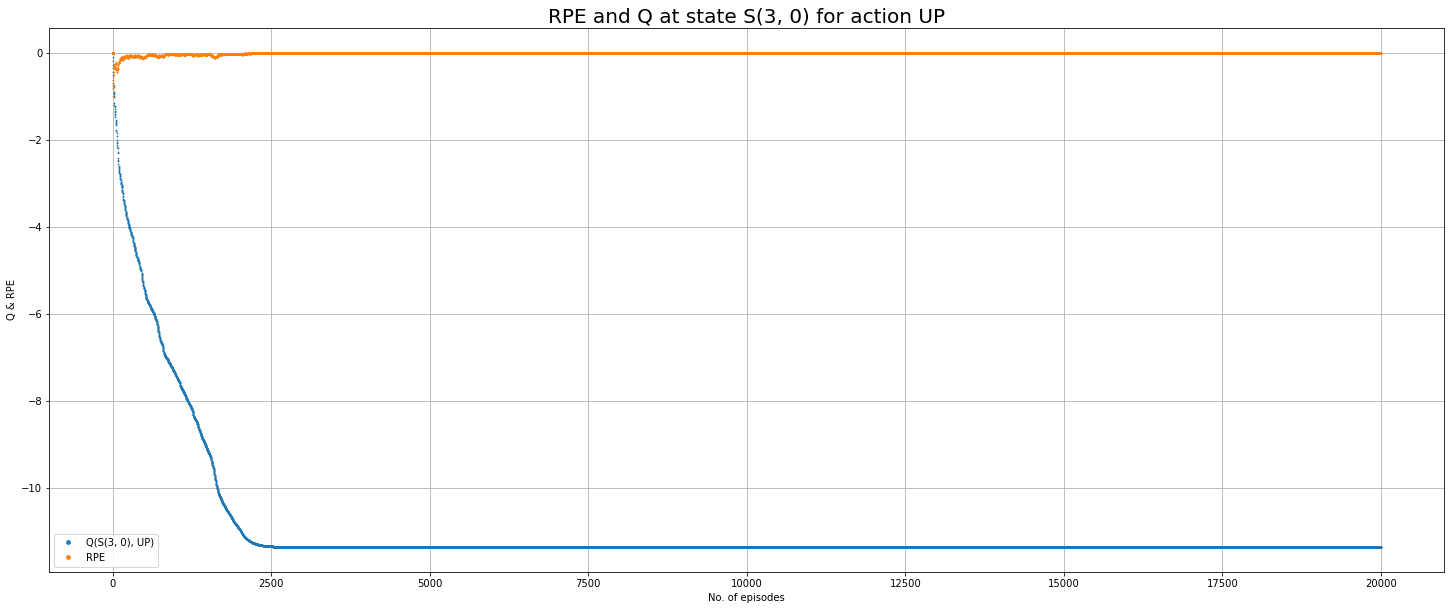

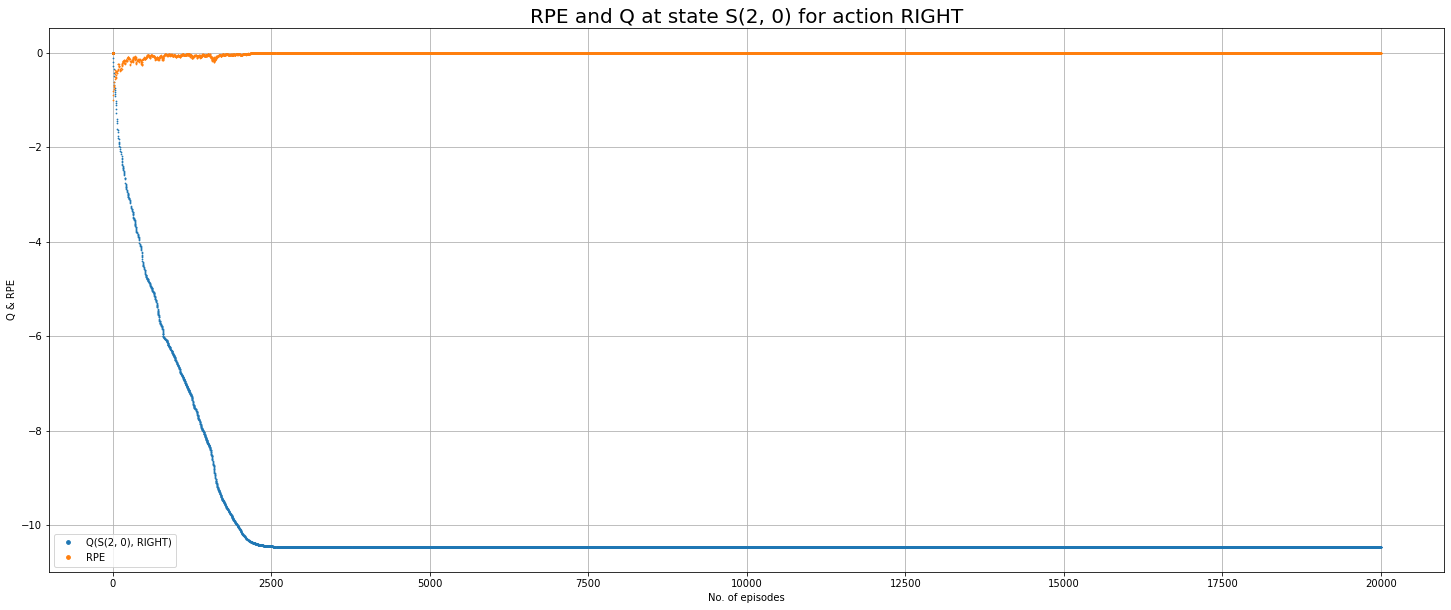

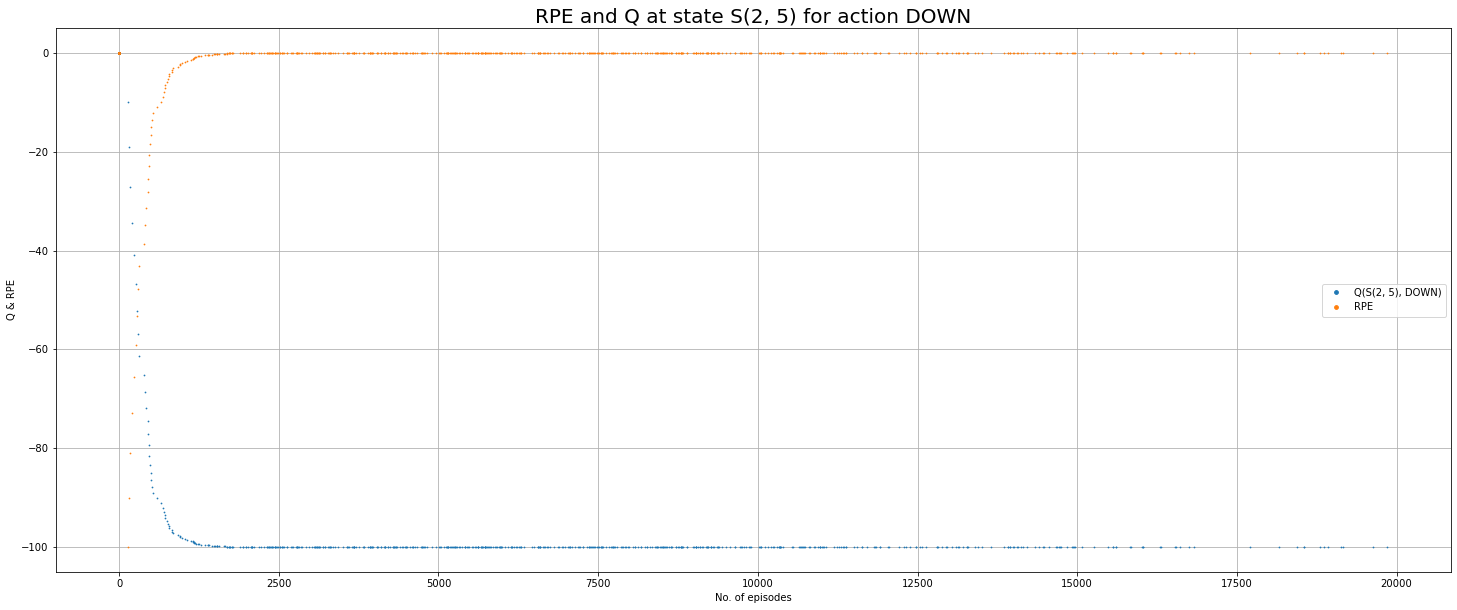

In [7]:
# Start position with action up
q_agent.plt_Q_RPE((3,0), 0)
# One above start position with action right
q_agent.plt_Q_RPE((2,0), 2)
# Position in middle of board with action down
q_agent.plt_Q_RPE((2,5), 1)